# Import Modules

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.calibration import calibration_curve

# Loading Dataset

In [351]:
df = pd.read_csv('SRSavg.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SRS_RAW_TOTAL      2050 non-null   int64  
 1   SRS_AWARENESS      2050 non-null   float64
 2   SRS_COGNITION      2050 non-null   float64
 3   SRS_COMMUNICATION  2050 non-null   float64
 4   SRS_MOTIVATION     2050 non-null   float64
 5   SRS_MANNERISMS     2050 non-null   float64
 6   HAS ADHD           2050 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 112.2 KB


# Data Preprocessing

In [352]:
feature_columns = ['SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS']
target_column = 'HAS ADHD'

X = df[feature_columns]
y = df[target_column]

df.head()

,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,HAS ADHD
0,38,3.0,7.0,15.0,6.0,7.0,0
1,35,8.0,6.0,15.0,4.0,2.0,0
2,32,5.0,7.0,9.0,3.0,8.0,0
3,68,10.0,15.0,22.0,15.0,6.0,0
4,54,6.0,11.0,15.0,8.0,14.0,0


# Split the Data Into Testing and Training

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Model

In [354]:
svm_model = SVC(probability=True)
param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}
random_search = RandomizedSearchCV(svm_model, param_distributions=param_grid, n_iter=5, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1}


# Predicting the Data

In [355]:
y_pred = best_model.predict(X_test)

# Conduct Accuracy and Report

In [356]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}")

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 98.78
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       205
           1       0.99      0.99      0.99       205

    accuracy                           0.99       410
   macro avg       0.99      0.99      0.99       410
weighted avg       0.99      0.99      0.99       410



# Evaluating the Model

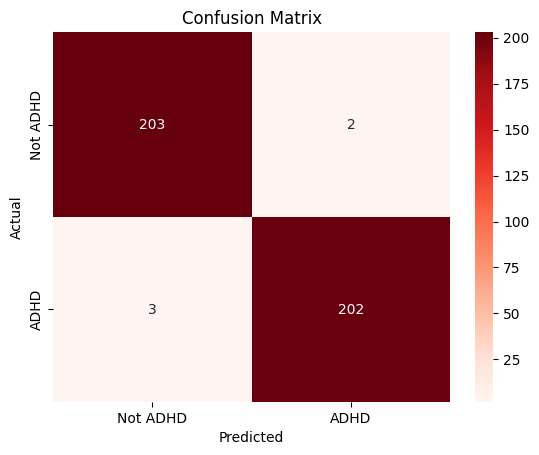

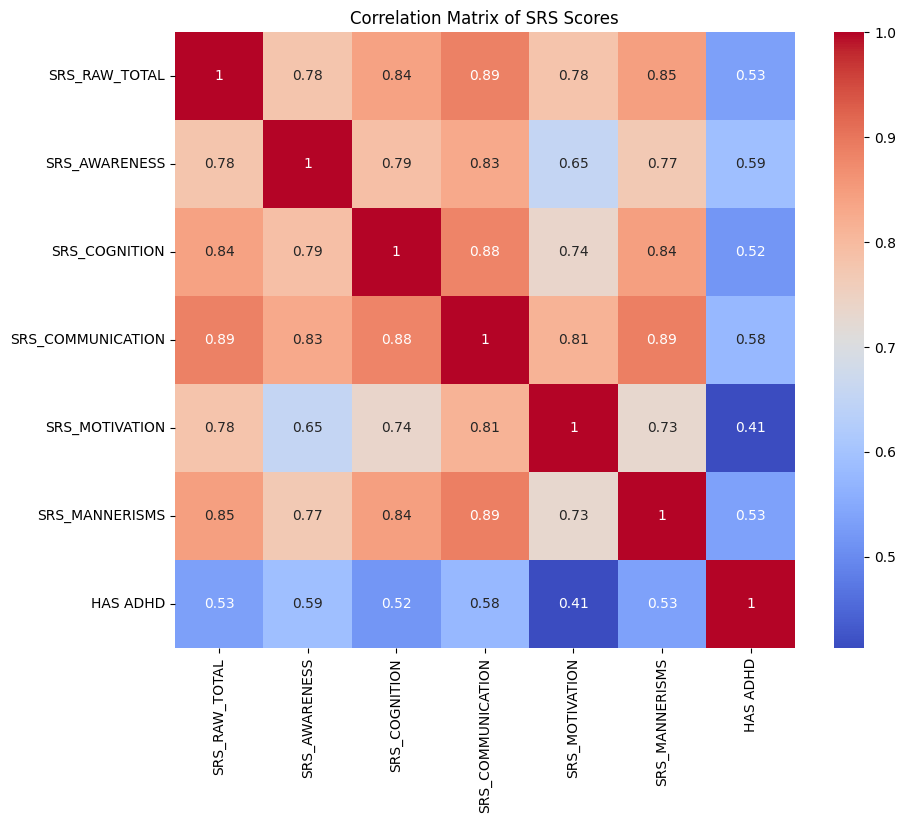

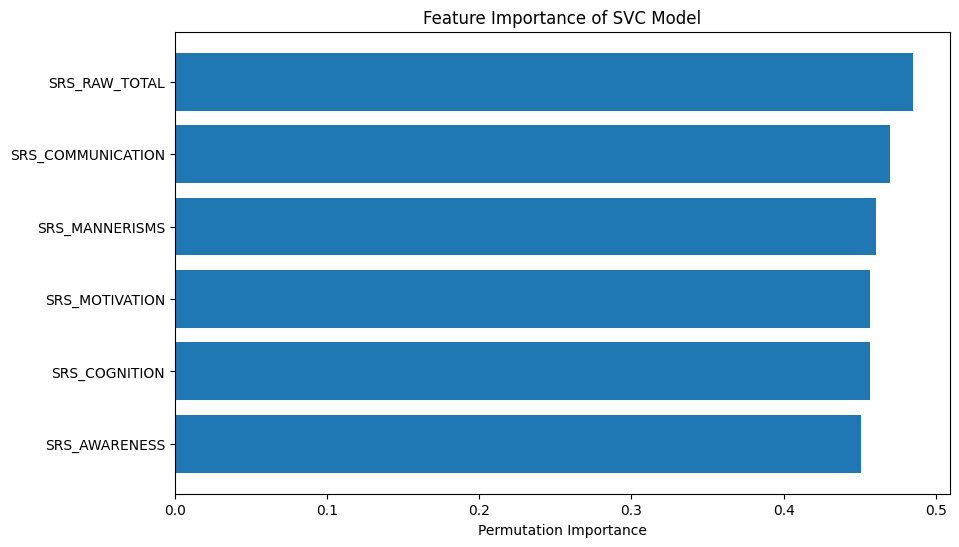

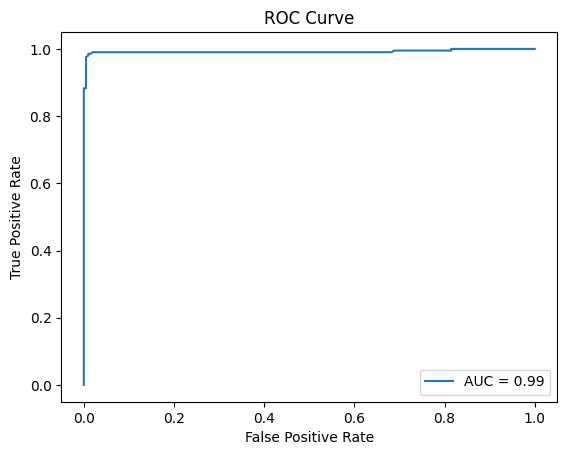

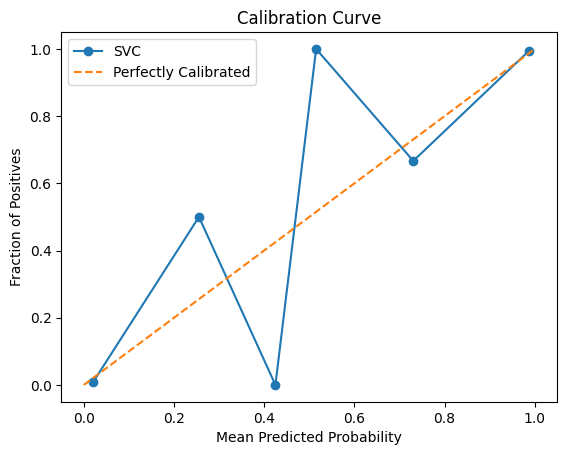

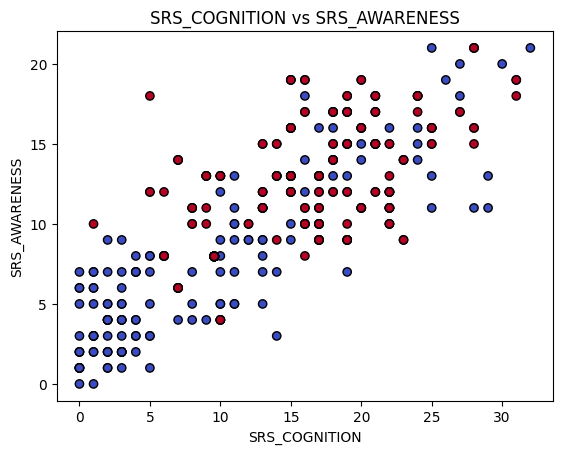

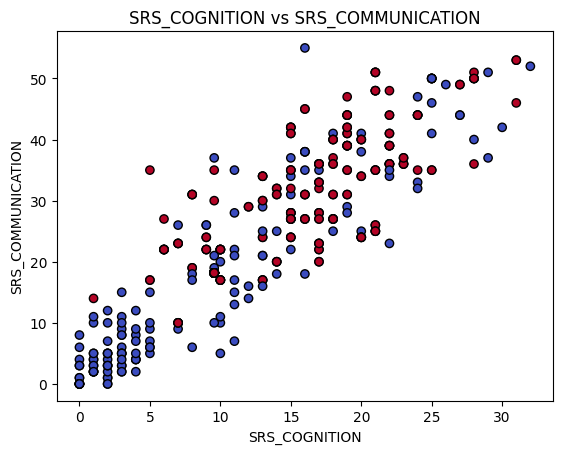

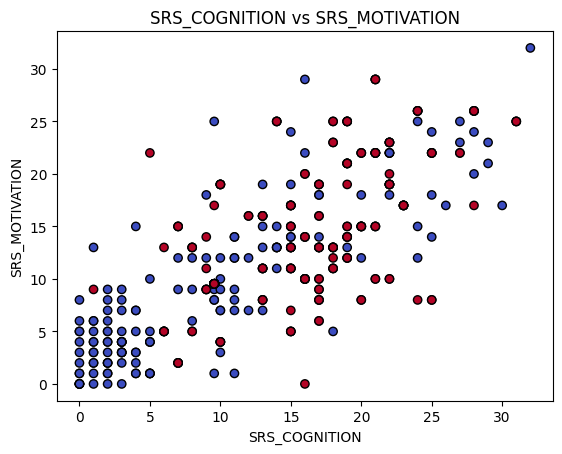

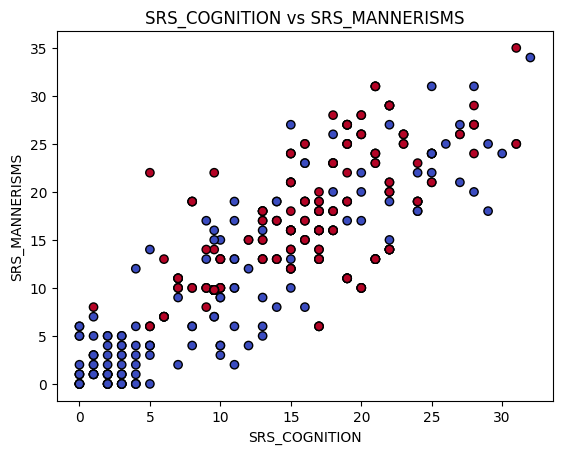

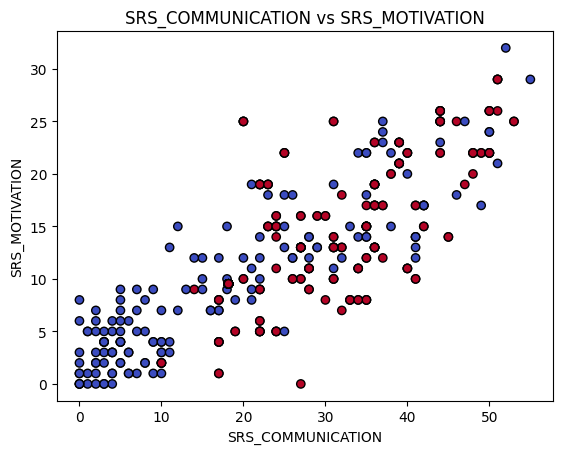

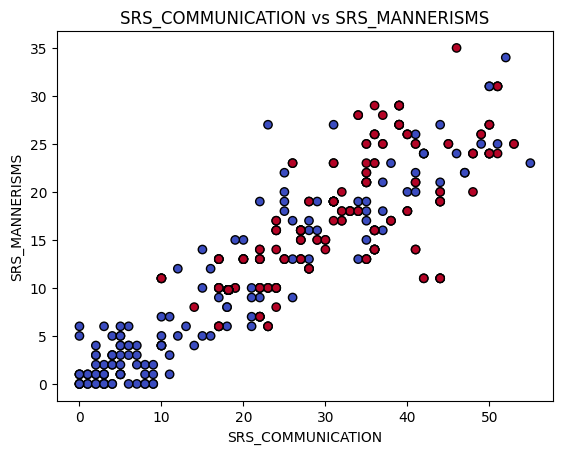

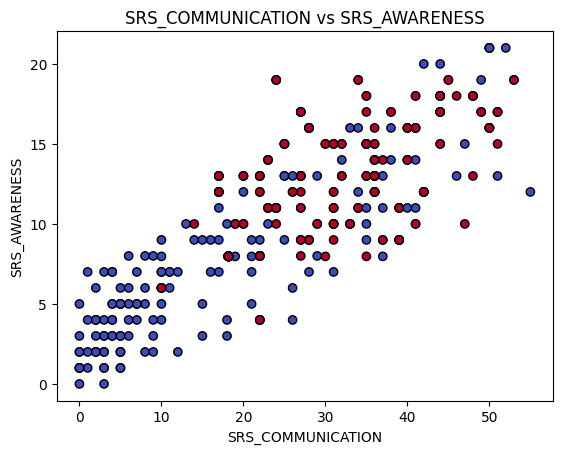

In [357]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Not ADHD", "ADHD"], yticklabels=["Not ADHD", "ADHD"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# Correlation matrix
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=corr.columns, yticklabels=corr.columns)
plt.title("Correlation Matrix of SRS Scores")
plt.show()


# Feature importance
perm_importance = permutation_importance(best_model, X, y, n_repeats=30, random_state=42, n_jobs=-1)
sorted_idx = perm_importance.importances_mean.argsort()
indices = np.argsort(perm_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance of SVC Model")
plt.show()


# ROC curve
y_score = best_model.predict_proba(X_test)[:, 1] 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:0.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Calibration curve
y_prob = best_model.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='SVC')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')  
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()


# Scatter Plot
srs_pairs = [
    ('SRS_COGNITION','SRS_AWARENESS'),
    ('SRS_COGNITION', 'SRS_COMMUNICATION'),
    ('SRS_COGNITION', 'SRS_MOTIVATION'),
    ('SRS_COGNITION', 'SRS_MANNERISMS'),
    ('SRS_COMMUNICATION', 'SRS_MOTIVATION'),
    ('SRS_COMMUNICATION', 'SRS_MANNERISMS'),
    ('SRS_COMMUNICATION', 'SRS_AWARENESS'),
]

for x_var, y_var in srs_pairs:
    plt.scatter(X_test[x_var], X_test[y_var], c=y_pred, cmap='coolwarm', marker='o', edgecolors='k')
    plt.title(f"{x_var} vs {y_var}")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()

# Visualising the Model Prediction

In [361]:
def classify(SRS_AWARENESS, SRS_COGNITION, SRS_COMMUNICATION, SRS_MOTIVATION, SRS_MANNERISMS):
    srs_scores = [SRS_AWARENESS, SRS_COGNITION, SRS_COMMUNICATION, SRS_MOTIVATION, SRS_MANNERISMS]
    total_srs_score = sum(srs_scores)
    
    input_data = pd.DataFrame(
        [[total_srs_score] + srs_scores],
        columns=['SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS'])

    prediction = best_model.predict(input_data)[0]
    probability = best_model.predict_proba(input_data)[0]
    
    result = "Prediction: No ADHD" if prediction == 0 else "Prediction: ADHD"
    prob_result = f"No ADHD: {probability[0]:.2f}, ADHD: {probability[1]:.2f}"

    return result, prob_result

interface = gr.Interface(
    fn=classify,
    inputs = [
        gr.Number(label="SRS Awareness Score"),
        gr.Number(label="SRS Cognition Score"),
        gr.Number(label="SRS Communication Score"),
        gr.Number(label="SRS Motivation Score"),
        gr.Number(label="SRS Mannerisms Score")
    ],
    outputs = [
        gr.Textbox(label="ADHD Classification Result"),
        gr.Textbox(label="Probability Scores") ],
    title="ADHD Classification",
    description="Enter the SRS scores to get an ADHD classification and probability."
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7893
* Running on public URL: https://88f39e55afaf7f8588.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
